sierpinski_python  
==== 
[work in progress]  
<br />
Mathematica
----

One of the things I was looking forward to was seeing people try to implement some of the Mathematica algorithms from my [Sierpinski triangle page](http://www.oftenpaper.net/sierpinski.htm) in different languages. A large portion of those programs don't have straightforward analogues in other languages. Particularly, most languages have either no notion of pattern matching, or they have only simple forms of it.

Python
--

To my disappointment I didn't even hear any cries of pain of people attempting translations. But because I'm a language geek, I don't mind doing the dirty work myself. And I also want to spread the joy beyond just Mathematica. Since Python is a standard now almost everywhere, it's a good choice, and I like Python as well. I'm happy there's at least one mainstream language whose aesthetics aren't hideous.

For this project I'm going to try to convert as many algorithms from the original page as I can that are "within reach". In truth the limitation isn't really going to be algorithmic, but rather logistical in terms of the relative availabilities/conceptual costs of libraries. I'm using the Anaconda Python 3.4 distribution with the IPython/Jupyter notebook interface. Since I'm new to the language I might miss useful libraries and so on. But generally I try not to overdo things with libraries regardless.

The module that I use for this page is [sierpinski.py](sierpinski.py). This notebook itself is [sierpinski_python.ipynb](sierpinski_python.ipynb). For the various display views I rely on [flipbook_ipy.js](flipbook-ipy.js) and [oftencss_ipy.css](oftencss_ipy.css).

1\. [triangle in triangle](http://www.oftenpaper.net/flipbook-triangleintriangle.htm)

Right away we hit a snag. How to display vector graphics? SVG is probably the best bet, since IPython has an SVG display function. No doubt there are good vector graphics libraries but it's simple enough that I would rather just make the kind of graphics system I want. Here is the graphics format I ended up with:

In [1]:
from sierpinski import *

graphics([
    ["opacity: .2; stroke: none",
        ["red", polygon([[0,0], [200,0],[200,200]])],
        ["blue", polygon([[0,0], [0,200], [200,200]])]],
    ["stroke: purple; stroke-opacity: .4;", line([[180,25], [25,180]])],
    "lightyellow", "stroke: none", disk([50,90], 25), disk([90,50], 25),
    "orange", rectangle(c=[146,146], wh=[50,50]),
        rectangle([[10,10],[30,30]]), rectangle([[30,30],[45,45]]),
    "fill: #888", rectangle(c=[102.5,102.5], wh=[7.5,7.5]),
    "stroke: #888; stroke-opacity: .6",
    line([[152,185],[185,185],[185,82]])])

OK, apparently I get carried away even when I'm just trying to demonstrate basic functionality. Here's a simpler demonstration:

In [2]:
graphics(["yellow", disk()])

Of course the fun is in it being programmatic.

In [3]:
from numpy.random import rand

angles = np.linspace(-.08, .08 + .5*np.pi, 25);

g1 = graphics(["stroke-opacity: .35; stroke-linejoin: round",
          "stroke-linecap: round; stroke-width: 3; stroke: gold",
          [line(circle_points(3, radial_offset=k+np.pi/1.73-np.pi)) for k in angles]],
        padding=1.05)

points = lambda k: circle_points(3, c=25*rand(2), radial_offset=k+np.pi/1.73-np.pi)

# if a string isn't a named color, it is interpreted as an inline style directive
g2 = graphics(["stroke-opacity: .25; stroke-linejoin: round; stroke-width: 1",
          "stroke: purple; fill: black; fill-opacity: .4",
          [polygon(rand()*points(k)) for k in angles]],
        padding=1.1)

Gallery([g1, g2], name="gallery1")

Testing <span name="gallery1" index="1" class="flipbookLink">testing</span>. 1 2 3 <span class="flipbookLink" name="gallery1" index="2">testing</span>.

In [4]:
n = 600
pts1 = circle_points(n);
pts2 = circle_points(n, radial_offset=np.pi/3)

graphics(["stroke-opacity: .2; stroke-linecap: round",
          [["stroke: hsl(" + str(i*360/n) +",100%,50%)", line([pts1[i],.478*pts2[i]])]
           for i in range(n)]],
         width=600, height=600)

Those who have used Mathematica will recognize the list-based graphics directives, which I've found convenient. A key difference is that in our Python version here, `line` is a strict function. It executes and returns something. In Mathematica, the `Line` *symbol* just remains in its unevaluated form, which lets us do further pattern matching or processing before we send it off to the `Graphics` function that interprets that structure as a visual line.

For the first Mathematica program, I use that capability by iteratively replacing each `Polygon` structure with 3 `Polygon` substructures, which is practically a direct translation of the mathematical description:

    axiom = Polygon[{{0, 0}, {1, Sqrt[3]}/2, {1, 0}}];

    next[prev_] := prev /. Polygon[{p1_, p2_, p3_}] :> {
         Polygon[{p1, (p1 + p2)/2, (p1 + p3)/2}],
         Polygon[{p2, (p2 + p3)/2, (p1 + p2)/2}],
         Polygon[{p3, (p1 + p3)/2, (p2 + p3)/2}]};

    draw[n_] := Graphics[{EdgeForm[Black],
        Nest[next, N@axiom, n]}];

In fact an even more direct form is possible in the form of a recursive definition. In Python we don't have these capabilities short of ill-advised domain-specific languages. Truthfully though we don't need anything fancy.

In [5]:
initial = [0, 500] - 500*np.array([[0, 0],[1/2, np.sqrt(3)/2],[1, 0]])

def subtriangles(pts, depth):
    if depth == 0:
        yield pts
    else:
        p1, p2, p3 = pts
        subtris = [[p1, (p1 + p2) / 2, (p1 + p3) / 2],
                   [p2, (p2 + p3) / 2, (p1 + p2) / 2],
                   [p3, (p1 + p3) / 2, (p2 + p3) / 2]];
        
        for subpts in subtris:
            yield from subtriangles(subpts, depth - 1)
        
Gallery([graphics(["fill: none; stroke: black; stroke-width: 2",
           [polygon(t) for t in subtriangles(initial, 3)]]),
         graphics([polygon(t) for t in subtriangles(initial, 3)])])

Thanks in large part to numpy's vectorizations, the code is about as good as the Mathematica version. For the iteration, a flat-map approach is probably what first comes to mind, but with generators we can avoid that kind of restructuring.

2\. [l system](http://www.oftenpaper.net/flipbook-l-system.htm)

Using the same generator approach we can handle the L-system algorithm quite well.

In [6]:
axiom = ['A'];
rules = {'A': ['B', 'R', 'A', 'R', 'B'],
         'B': ['A', 'L', 'B', 'L', 'A']}

angle_rules = {'A': 0, 'B': 0, 'L': -2*np.pi/6, 'R': 2*np.pi/6}

def lsystem(chars, depth):
    if depth == 0:
        yield from chars
    else:
        for f in chars:
            yield from lsystem(rules.get(f, f), depth - 1)
            
angles = [angle_rules.get(sym, 0) for sym in list(lsystem(axiom, 6))]

a, d = -np.pi/3, 3
path = [0]*(len(angles)+1)

for i in range(len(angles)):
    a += angles[i]
    path[i+1] = path[i] + d*np.e**(1j*a)
    
graphics(["stroke-width: 2; stroke-linejoin: round", line([re_im(z) for z in path])])

The pure symbol output after a few iterations:

In [7]:
print(list(lsystem(axiom, 3)))

['B', 'R', 'A', 'R', 'B', 'L', 'A', 'L', 'B', 'L', 'A', 'L', 'B', 'R', 'A', 'R', 'B', 'R', 'A', 'L', 'B', 'L', 'A', 'R', 'B', 'R', 'A', 'R', 'B', 'R', 'A', 'L', 'B', 'L', 'A', 'R', 'B', 'R', 'A', 'R', 'B', 'L', 'A', 'L', 'B', 'L', 'A', 'L', 'B', 'R', 'A', 'R', 'B']


See also:

In [8]:
angles = [0, 0] + [angle_rules.get(sym, 0) for sym in list(lsystem(axiom, 7))]
zs = np.cumsum(2*np.exp(1j*np.cumsum(angles)))
path = line([re_im(z) for z in zs])
path_offset = line([re_im(z) for z in zs - 1.75*(.3 + 1j)])

graphics(["stroke-linejoin: round",
        ["stroke-width: 7", "stroke: red; stroke-opacity: .02", path],
        ["stroke-width: 6", "stroke: blue; stroke-opacity: .15", path],
        ["stroke-width: 4; stroke-opacity: .4", path],
        ["stroke-width: 2.5", "stroke: white", path_offset]], width=1000, height=1000)

3\. [cellular automata 1](http://www.oftenpaper.net/flipbook-cellularautomata1.htm)

As Mathematica often does, it cheats here by having a dedicated cellular automaton processor as a built-in function. It's a very customizable function, but for our purposes we only need the basic range-1 automata.

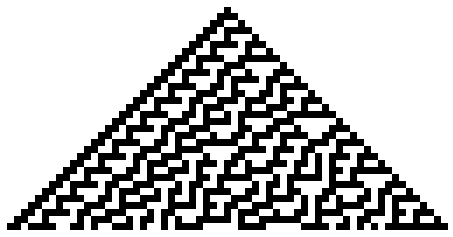

In [9]:
%matplotlib inline

tos = [map(int, reversed(format(n, "08b"))) for n in range(256)]
froms = [tuple(map(int, format(n, "03b"))) for n in range(8)]
rules = [dict(zip(froms, to)) for to in tos]

def cellular_automaton(N, steps=1, center=[1], background=0):
    state = [background]*steps + center + [background]*steps
    L = len(state)
    
    yield(state)
    for i in range(steps):
        nears = [(state[(i-1) % L], state[i], state[(i+1) % L]) for i in range(L)]
        state = [rules[N][near] for near in nears]
        yield state

array_plot(1 - np.array(list(cellular_automaton(30, 31))))

After a good fight I managed to get a basic image to show up in the notebook. Woo hoo. By comparison the cellular automaton function itself was easy. A cleaner display form I ran into *after* I stopped looking for it:

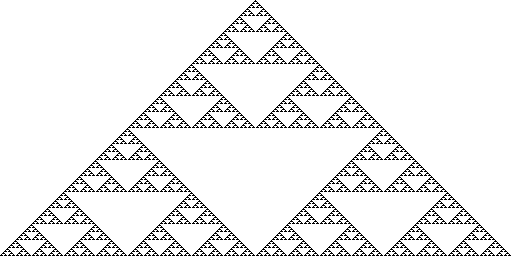

In [10]:
import scipy.misc as misc
misc.toimage(1-np.array(list(cellular_automaton(22, 2**8 - 1))))

4\. [pascal's triangle](http://www.oftenpaper.net/flipbook-pascal'striangle.htm)

We can quickly generate a Pascal grid from the binomial coefficient:

In [11]:
import scipy.misc as misc

def pascal_grid(size):
    return [[misc.comb(a, b, exact=True) for a in range(size)] for b in range(size)]

str(pascal_grid(8))

'[[1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 2, 3, 4, 5, 6, 7], [0, 0, 1, 3, 6, 10, 15, 21], [0, 0, 0, 1, 4, 10, 20, 35], [0, 0, 0, 0, 1, 5, 15, 35], [0, 0, 0, 0, 0, 1, 6, 21], [0, 0, 0, 0, 0, 0, 1, 7], [0, 0, 0, 0, 0, 0, 0, 1]]'

But since we're pretty gimped here in terms of layout, we'll have to settle for a simpler way of showing the odd numbers in Pascal's triangle:

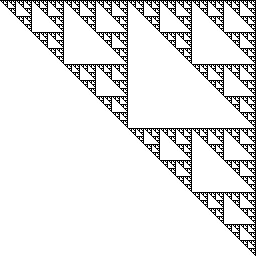

In [12]:
modulus = 2
misc.toimage(1 - np.array(pascal_grid(2**8)) % modulus)

But wait. What do I mean "gimped"? This is the internet by golly! Let's rewind that back and reformat our defeatist mindset. We can create a triangular Pascal array like so:

In [13]:
import scipy.misc as misc

def pascal_array(size):
    return [[misc.comb(b, a, exact=True) for a in range(b+1)] for b in range(size)]

str(pascal_array(8))

'[[1], [1, 1], [1, 2, 1], [1, 3, 3, 1], [1, 4, 6, 4, 1], [1, 5, 10, 10, 5, 1], [1, 6, 15, 20, 15, 6, 1], [1, 7, 21, 35, 35, 21, 7, 1]]'

With just some HTML/CSS stuff we can get the same kind of ad-hoc layout I made in Mathematica:

In [14]:
style = lambda n: "" if n % 2 else "border: 1px lightgray dotted; color: lightgray"
Column([Row([Frame(el, style=style(el)) for el in row]) for row in pascal_array(8)])

Wooo.

In [15]:
style = lambda n: "" if n % 2 else "border: 1px lightgray dotted; color: lightgray; border-radius: 6px;"
Column([Row([Frame(el, style="display: block; border-radius: 6px; " + style(el)) for el in row]) for row in pascal_array(16)])

Woo!

In the process I also made a good list display:

In [16]:
List(pascal_array(16))

In [17]:
List([graphics(["greenyellow", "stroke: none", disk()]), Table(np.identity(5)),
      graphics(["green", "stroke: none", disk()]), Table(np.identity(5)[::-1]),
      graphics(["yellowgreen", "stroke: none", disk()])])

1.0,0.0,0.0,0.0,0.0
0.0,1.0,0.0,0.0,0.0
0.0,0.0,1.0,0.0,0.0
0.0,0.0,0.0,1.0,0.0
0.0,0.0,0.0,0.0,1.0
0.0,0.0,0.0,0.0,1.0
0.0,0.0,0.0,1.0,0.0
0.0,0.0,1.0,0.0,0.0
0.0,1.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0


In [18]:
List([graphics(['stroke: none; fill: ' + RGB(50, g, g),  disk()], width=23, height=23)
      for g in range(210, 110, -1)])

In [19]:
ls = [EventHandler(
        graphics(['stroke: none; fill: ' + RGB(50, g, g), Attributes(disk(r=50), **{'class': 'outerCirc'}),
                  "black", Attributes(disk(r=25), **{'class': 'innerCirc', 'style': 'opacity: .15'})], width=23, height=18),
        onmouseover=Javascript("""
            var circ = $(event.target).find(".outerCirc");
            var size = parseInt(circ.css("r"), 10);
            circ.animate({opacity: .5, r: size / 2}, 1200)
                .animate({opacity: 1}, 1000);

            circ = $(event.target).find(".innerCirc");
            size = parseInt(circ.css("r"), 10);
            circ.animate({opacity: .05, r: 2 * size}, 2200)
                .animate({opacity: 1}, 1800);
                """))
      for g in range(215, 115, -1)]

Column([Table(np.split(np.array(ls), 10), id="prettytable"),
        EventHandler("Reset",
             style='border: 1px solid rgba(50, 170, 170, .7); background: rgba(50, 140, 140, .03);'
                    + 'border-radius: 4px; display: block;  text-align: center; cursor: pointer',
             onclick=Javascript("""
                 $("#prettytable").find(".outerCirc").animate({r: 50}, 110);
                 $("#prettytable").find(".innerCirc").animate({r: 25, opacity: .3}, 1000);
                 """))])

5\. [pascal matrix exp](http://www.oftenpaper.net/flipbook-pascalmatrixmodhat.htm)

The matrix exponential in Mathematica:

    ArrayPlot[Mod[MatrixExp[DiagonalMatrix[Range[n], -1]], 2]];
    
Is similarly easy in Python thanks to the relevant matrix operations and vectorization:

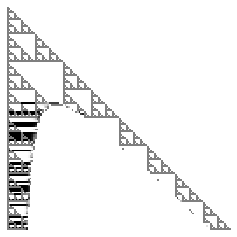

In [20]:
from scipy import linalg

n = 2**7
array_plot(1 - linalg.expm3(np.diag(range(1, n), -1), n) % 2)

Sort of. As you can see we run into precision issues early, but the exact calculation of this algorithm is slow anyway. Lets skip ahead to the randomized version of the algorithm.

6\. [chaos game](http://www.oftenpaper.net/flipbook-chaosgame.htm)

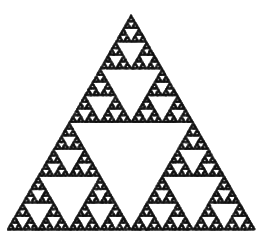

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

vertices = np.array([[0, 0],[1/2, np.sqrt(3)/2],[1, 0]])

def chaos_game(vertices, n):
    pts = vertices[np.random.choice(len(vertices), n)]

    ls = [[0,0]]*n
    for i in range(n-1):
        ls[i+1] = (ls[i] + pts[i])/2
    
    return ls

point_plot(chaos_game(vertices, 100000), markersize=.14)

Easily generalized:

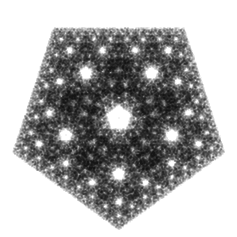

In [22]:
point_plot(chaos_game(-2*circle_points(5, radial_offset=np.pi/10), 200000), markersize=.1)

For the next few ones we're going to need to be able to plot graphs. I found the NetworkX library and managed to get this:

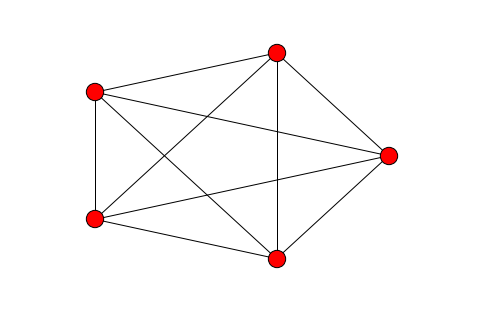

In [23]:
%matplotlib inline
import networkx as nx

nx.draw_circular(nx.complete_graph(5))

Which isn't the worst graphics I've ever seen, but being on the internet we can do better.

In [24]:
Graph(nx.complete_graph(5))

This `sierpinski.Graph` is a simple D3.js layer on top of the NetworkX Graph class, where the NetworkX functions smartly re-use it:

In [25]:
Table(np.transpose([[g, nx.line_graph(g)] for g in
                    [Graph(nx.complete_graph(k)) for k in range(3, 7)]]))

,,,
,,,


Wooo!

[work in progress]